Intro
In this archive, you will find three datasets describing a marketing campaign 
run by WidgetCo. This campaign was sent as part of a campaign to reengage customers 
who had bought a widget the previous year. The datasets are as follows:
- email_data.csv: a file containing email send, open, and click events for this campaign over one month
- orders.csv: a file containing events for purchases of WidgetCo's products.
- params.csv: a file containing parameters describing WidgetCo's customers.

On the basis of your analysis of these three files, report to WidgetCo whether 
the campaign was effective, and where or how it was most effective. Identify a 
specific set of customers who should receive a follow-up campaign or campaigns, 
and describe the content of those campaigns.

Format
As possible, please return your analysis as a document or notebook readable by
statistically literate peers, with summaries as necessary to make it
comprehensible to business/marketing stakeholders.

Any code you use to generate the analysis should be returned as well, in a 
runnable format.


# Objectives

- Report to WidgetCo whether the campaign was effective, and where or how it was most effective. (Measuring effectiveness)
- Identify a specific set of customers who should receive a follow-up campaign or campaigns (targeting, Segmentation, response and uplift modeling)
- describe the content of those campaigns.

# Exploratory Data Analysis

In [52]:
import pandas as pd 
import numpy as np
from pathlib import Path
from functools import partial 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython import html, display



np.random.seed(1234)
warnings.filterwarnings('ignore')
plt.ion()
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['font.size'] =  16

In [53]:
ROOT = Path('./')
DATA = ROOT/'data'

In [54]:
to_datetime = partial(pd.to_datetime, unit='s')


param_df = pd.read_csv(DATA/'params.csv', #index_col='id',
                       parse_dates=['first_order_date',
                                    'last_order_date'], 
                       date_parser=to_datetime)

email_df = pd.read_csv(DATA/'email_data.csv', #index_col='id',
                       parse_dates=['event_time'], 
                       date_parser=to_datetime)

orders_df = pd.read_csv(DATA/'orders.csv', #index_col='id',
                        parse_dates=['event_time'],
                        date_parser=to_datetime)

In [55]:
param_df.info(); print('\n'); email_df.info(); print('\n'); orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307992 entries, 0 to 1307991
Data columns (total 8 columns):
id                       1307992 non-null object
has_purchased_widget     512207 non-null object
has_purchased_trinket    512207 non-null object
has_purchased_gizmo      512207 non-null object
order_count              512207 non-null float64
first_order_date         512207 non-null datetime64[ns]
last_order_date          512207 non-null datetime64[ns]
lifetime_revenue         512116 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 79.8+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375626 entries, 0 to 375625
Data columns (total 3 columns):
id            375626 non-null object
event_time    375626 non-null datetime64[ns]
event_type    375626 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 8.6+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44193 entries, 0 to 44192
Data columns (total 5 columns):
product      

## Orders dataset

In [56]:
print(f'oldest order: {orders_df["event_time"].min()}, last order: {orders_df["event_time"].max()}')

oldest order: 2017-04-22 00:00:27, last order: 2017-05-21 23:58:50


In [57]:
# cat_col = ['product', 'event_type']
# for col in cat_col:
#     orders_df[col] = orders_df[col].astype('category')
    
orders_df.describe(include='all')

,product,event_type,event_time,id,revenue
count,44193,44193,44193,44193,44193.000000
unique,4,1,29886,27149,NaN
top,other,promo_order,2017-04-22 11:09:10,8e8b9563-9f54-434f-b329-aab787f9b44f,NaN
freq,14404,44193,13,46,NaN
first,NaN,NaN,2017-04-22 00:00:27,NaN,NaN
last,NaN,NaN,2017-05-21 23:58:50,NaN,NaN
mean,NaN,NaN,NaN,NaN,73.303170
std,NaN,NaN,NaN,NaN,80.512492
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,17.000000


In [58]:
# should i drop duplicates 
orders_df.drop_duplicates().shape

(44046, 5)

In [59]:
orders_df.dropna(how='all').shape

(44193, 5)

In [60]:
orders_df.head()
# orders_df.set_index('event_time', inplace=True)

,product,event_type,event_time,id,revenue
0,trinket,promo_order,2017-04-22 00:00:31,1fd28d09-3636-46a1-960a-351dac621e87,15
1,gizmo,promo_order,2017-04-22 00:07:19,858754f9-da05-4c2a-ac98-eadc27bcbe81,28
2,trinket,promo_order,2017-04-22 00:10:43,c0bb1769-78f0-488b-95db-73cc1c50f07e,17
3,other,promo_order,2017-04-22 00:17:47,f70496a6-5819-4825-ae23-a49e508c53f8,40
4,other,promo_order,2017-04-22 00:35:32,acaea947-b67c-48c2-aca5-7d265394418d,27


In [61]:
orders_df['event_type'].unique()

array(['promo_order'], dtype=object)

#### Products ordered 

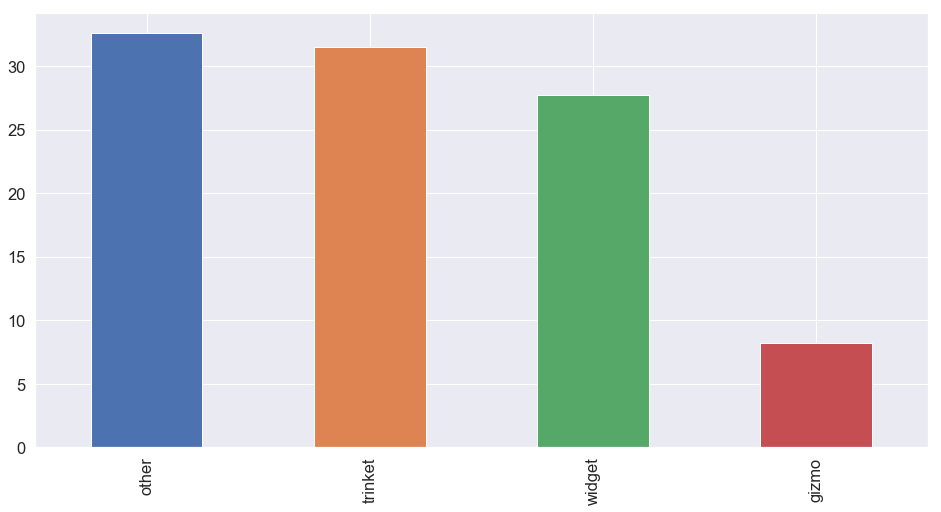

In [62]:
(100 * orders_df['product'].value_counts() / orders_df['product'].value_counts().sum()).plot('bar')

In [63]:
orders_df.drop_duplicates(inplace=True)

In [64]:
temp = pd.pivot_table(orders_df, values='revenue', index='event_time', columns='product', aggfunc=np.sum)
temp.head()

product,gizmo,other,trinket,widget
event_time,,,,
2017-04-22 00:00:27,NaN,NaN,30.0,NaN
2017-04-22 00:00:31,NaN,NaN,15.0,NaN
2017-04-22 00:07:19,28.0,NaN,NaN,NaN
2017-04-22 00:10:43,NaN,NaN,17.0,NaN
2017-04-22 00:11:54,NaN,NaN,14.0,NaN


#### Number of orders and revenue during the campaign 

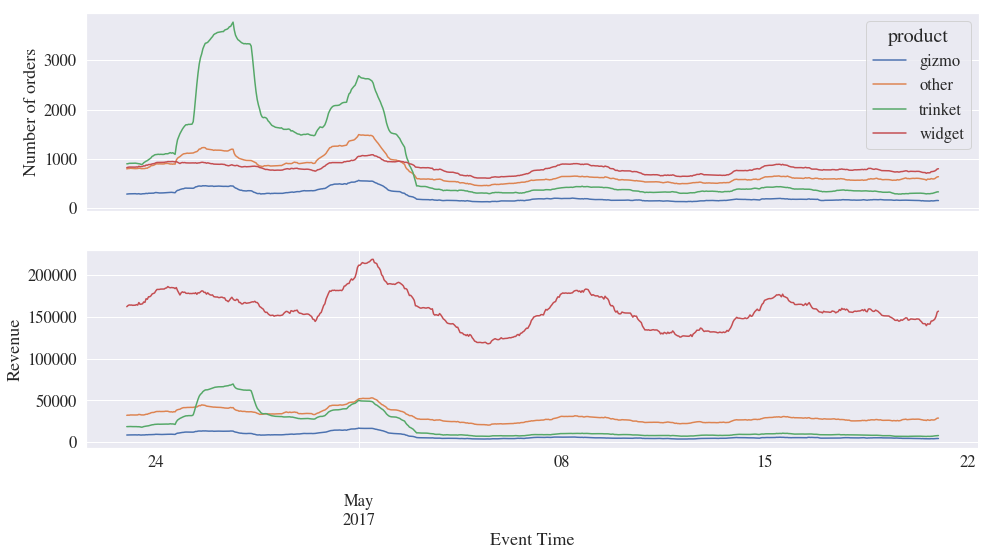

In [417]:
fig, ax = plt.subplots(2)
dat = temp.resample('1H').count().rolling(48 , center=True).sum()
dat.plot(ax=ax[0])
ax[0].set_ylabel('Number of orders')
ax[0].axes.get_xaxis().set_visible(False)
dat = temp.resample('1H').sum().rolling(48 , center=True).sum()
dat.plot(ax=ax[1])
ax[1].set_ylabel('Revenue')
# ax[1].axes.get_xaxis().set_ticklabels(dat.index.date, rotation=90)
ax[1].legend_.remove()
ax[1].set_xlabel('Event Time')
fig.savefig('./image/figure1.png', bbox_inches='tight', dpi=300)


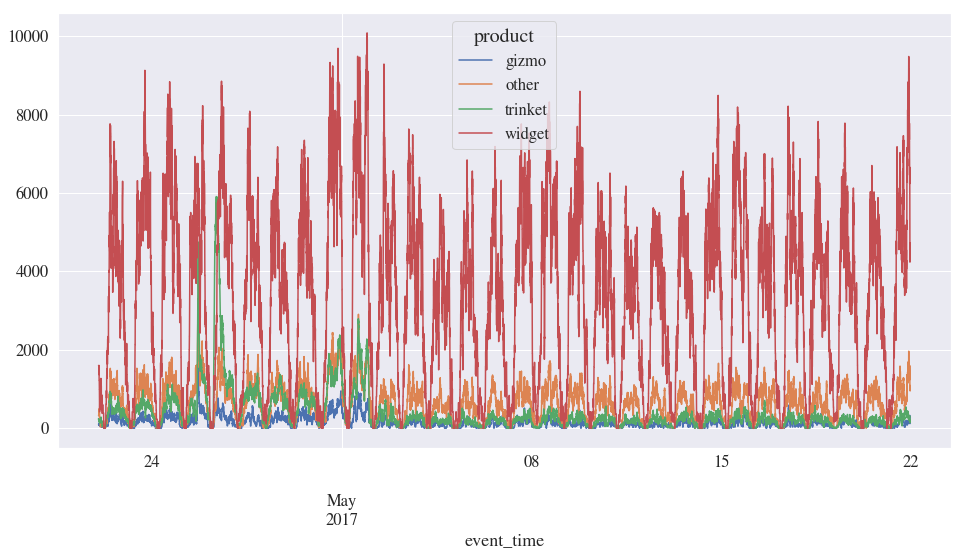

In [283]:
temp.resample('60s').sum().rolling(60, center=True).sum().plot()

#### Mean orders at each hour of the day

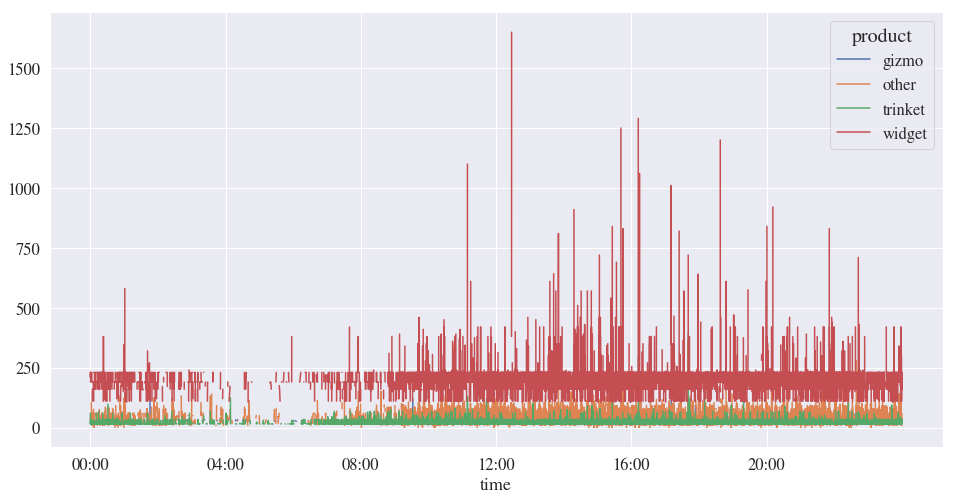

In [301]:
by_time = temp.groupby(temp.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks)

#### orders at each day of the week 

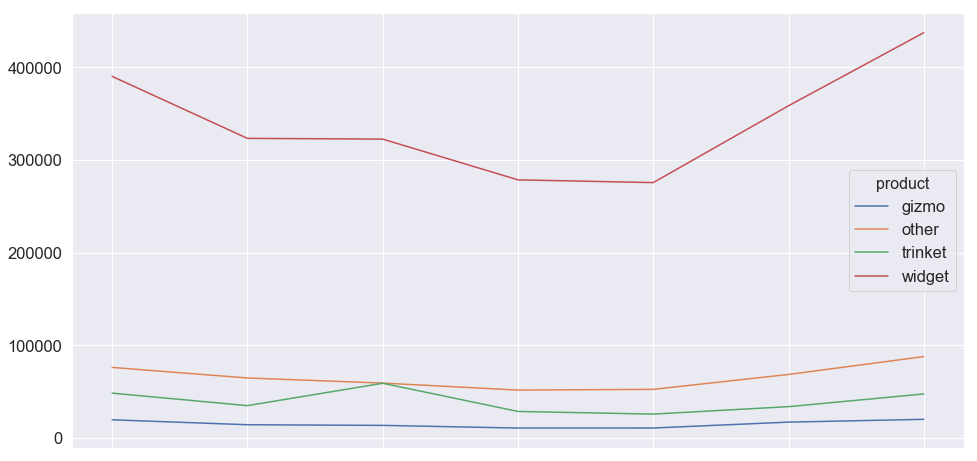

In [65]:
by_time = temp.groupby(temp.index.dayofweek).sum()
by_time.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_time.plot()

#### Distribution of revnue for each product

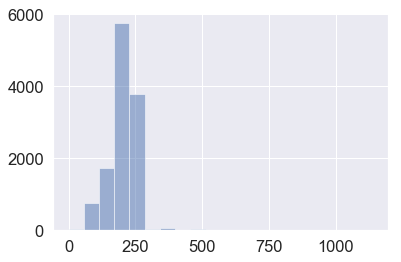

In [19]:
orders_df[orders_df['product'] == 'widget']['revenue'].hist(bins=20, alpha=.5)

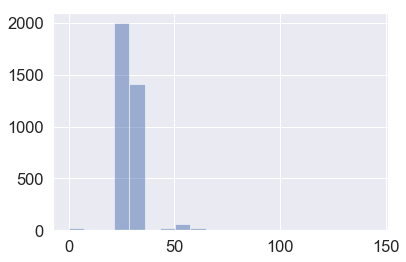

In [20]:
orders_df[orders_df['product'] == 'gizmo']['revenue'].hist(bins=20, alpha=.5)

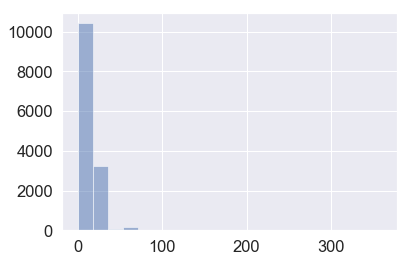

In [21]:
orders_df[orders_df['product'] == 'trinket']['revenue'].hist(bins=20, alpha=.5)

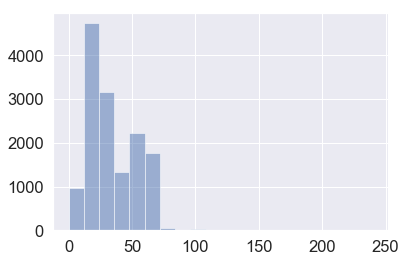

In [22]:
orders_df[orders_df['product'] == 'other']['revenue'].hist(bins=20, alpha=.5)

#### Costumers with highest number of orders

In [23]:
orders_df.groupby('id')['revenue'].count().sort_values(ascending=False).head()

id
8e8b9563-9f54-434f-b329-aab787f9b44f    46
baadb1b6-d4cc-45fc-87de-b116237ed16a    28
7dfabc00-3344-465c-81fd-79687f1f8f2b    16
86113d05-3d8e-4ecc-a96a-38733f80d93a    14
b57623f8-4b4d-4108-ada0-a4e5cade3a2f    12
Name: revenue, dtype: int64

## Parameters dataset

In [27]:
param_df.shape, param_df.drop_duplicates().shape

((1307992, 8), (1307992, 8))

In [28]:
param_df.columns

Index(['id', 'has_purchased_widget', 'has_purchased_trinket',
       'has_purchased_gizmo', 'order_count', 'first_order_date',
       'last_order_date', 'lifetime_revenue'],
      dtype='object')

#### Number of that have order something in the past

In [29]:
param_df.dropna(how='all',
               subset=['has_purchased_widget', 'has_purchased_trinket',
       'has_purchased_gizmo', 'order_count', 'first_order_date',
       'last_order_date', 'lifetime_revenue']).shape

(512207, 8)

In [30]:
param_df.head()

,id,has_purchased_widget,has_purchased_trinket,has_purchased_gizmo,order_count,first_order_date,last_order_date,lifetime_revenue
0,b559a1d3-5599-4223-92fb-f68d35f8bcb8,f,t,f,1.0,2017-01-23,2017-01-23,1700.0
1,fcd46843-a4a3-4c7b-bd89-14847303f566,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,05017c37-180b-4122-a528-0f5c78fc1010,NaN,NaN,NaN,NaN,NaT,NaT,NaN
3,5b41894b-52da-4269-9502-1b9eb0974193,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,2f74bc5c-c1c5-4a7a-a04d-e594d989a5ea,NaN,NaN,NaN,NaN,NaT,NaT,NaN


In [226]:
param_df.describe(include='all')

,id,has_purchased_widget,has_purchased_trinket,has_purchased_gizmo,order_count,first_order_date,last_order_date,lifetime_revenue
count,1307992,512207,512207,512207,512207.000000,512207,512207,5.121160e+05
unique,1307992,2,2,2,NaN,1200,1200,NaN
top,b755926d-3ed5-4fcb-9514-c46ee3e705d5,t,f,f,NaN,2017-04-26 00:00:00,2017-04-26 00:00:00,NaN
freq,1,405617,359310,461688,NaN,2518,2932,NaN
first,NaN,NaN,NaN,NaN,NaN,2014-04-22 00:00:00,2014-04-22 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-08-03 00:00:00,2017-08-03 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,1.193336,NaN,NaN,1.708133e+04
std,NaN,NaN,NaN,NaN,1.932172,NaN,NaN,1.293264e+04
min,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,4.000000e+02
25%,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.240000e+04


In [32]:
param_df.dropna(how='all',
               subset=['has_purchased_widget', 'has_purchased_trinket',
       'has_purchased_gizmo', 'order_count', 'first_order_date',
       'last_order_date', 'lifetime_revenue']).describe(include='all')

,id,has_purchased_widget,has_purchased_trinket,has_purchased_gizmo,order_count,first_order_date,last_order_date,lifetime_revenue
count,512207,512207,512207,512207,512207.000000,512207,512207,5.121160e+05
unique,512207,2,2,2,NaN,1200,1200,NaN
top,19ce3747-c947-469c-86cd-84d84adac694,t,f,f,NaN,2017-04-26 00:00:00,2017-04-26 00:00:00,NaN
freq,1,405617,359310,461688,NaN,2518,2932,NaN
first,NaN,NaN,NaN,NaN,NaN,2014-04-22 00:00:00,2014-04-22 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-08-03 00:00:00,2017-08-03 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,1.193336,NaN,NaN,1.708133e+04
std,NaN,NaN,NaN,NaN,1.932172,NaN,NaN,1.293264e+04
min,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,4.000000e+02
25%,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.240000e+04


In [33]:
param_df.drop_duplicates().shape

(1307992, 8)

#### Ids with high number of orders

In [34]:
param_df.sort_values(by='order_count', ascending=False).head(10)

,id,has_purchased_widget,has_purchased_trinket,has_purchased_gizmo,order_count,first_order_date,last_order_date,lifetime_revenue
574710,13543c1a-f3ec-4aea-b349-22b4cd94006c,t,t,t,799.0,2015-07-16,2017-06-21,2183417.0
1189079,358dddf1-a228-4e88-bfd8-73056e64fbb6,t,f,f,560.0,2016-09-01,2017-04-28,58883.0
601706,86113d05-3d8e-4ecc-a96a-38733f80d93a,t,t,t,498.0,2016-12-09,2017-06-27,516500.0
469602,b3b3b8d9-86b1-4a94-a7a3-58b09049a095,t,t,t,405.0,2014-12-18,2017-07-28,621600.0
279362,89c7ad26-d304-4e90-92fa-4b5255d40dda,t,t,t,397.0,2016-06-23,2017-08-01,252900.0
994500,9d8e721d-7643-4efb-a36c-5af338558dc0,t,t,t,222.0,2015-05-26,2017-04-07,3552371.0
857040,6ba81b98-8993-4d5d-b476-1b9795c51d71,t,f,f,167.0,2015-06-11,2015-06-11,17057.0
1070788,1ceba1a8-72f2-4806-be86-cf1fb277dbf1,t,t,t,160.0,2015-12-14,2017-07-05,190200.0
1210014,b63e0e16-fcdd-4b24-abcc-b845dfd582ce,t,t,t,128.0,2015-12-23,2016-04-05,150900.0
905940,fe751c49-9932-4367-879f-5165648d88e1,t,t,t,108.0,2015-12-09,2016-07-01,47575.0


#### Ids with high lifetime revenue

In [35]:
param_df.sort_values(by='lifetime_revenue', ascending=False).head(10)

,id,has_purchased_widget,has_purchased_trinket,has_purchased_gizmo,order_count,first_order_date,last_order_date,lifetime_revenue
994500,9d8e721d-7643-4efb-a36c-5af338558dc0,t,t,t,222.0,2015-05-26,2017-04-07,3552371.0
574710,13543c1a-f3ec-4aea-b349-22b4cd94006c,t,t,t,799.0,2015-07-16,2017-06-21,2183417.0
294348,d64836ca-a6b2-49a0-9929-fab2bddf2af2,t,t,t,16.0,2016-10-27,2017-03-30,1181200.0
1221882,b3a1b375-75bb-437c-9f93-b08bca2765ab,t,t,t,74.0,2014-10-16,2017-01-24,1040300.0
963529,094604c1-9b46-4f56-af07-809d5ec8edbe,t,t,t,37.0,2015-12-16,2017-07-27,837900.0
393494,82d01a88-b3b9-477f-a828-6bce8871b091,t,t,t,48.0,2015-12-29,2017-05-23,760400.0
771080,f43a6bc2-2008-4c76-a5ba-689cc89330ba,t,t,f,10.0,2016-12-19,2017-06-02,654500.0
853112,3902e80a-1ad7-4587-96ef-f8dfbe7bbf07,t,t,t,19.0,2016-03-30,2016-10-21,640600.0
469602,b3b3b8d9-86b1-4a94-a7a3-58b09049a095,t,t,t,405.0,2014-12-18,2017-07-28,621600.0
285990,3b915ad3-5853-47da-a5ba-2736903b16ed,t,t,f,5.0,2015-10-26,2016-12-03,590000.0


#### Distribution of lifetime revenue, 

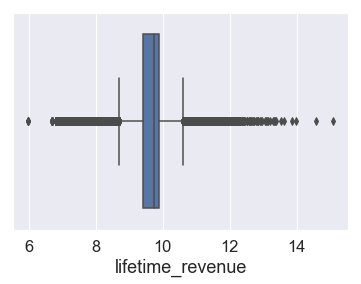

In [37]:
sns.boxplot(np.log(param_df['lifetime_revenue'].dropna() + 0.001))

#### Distribution of orders and revenue

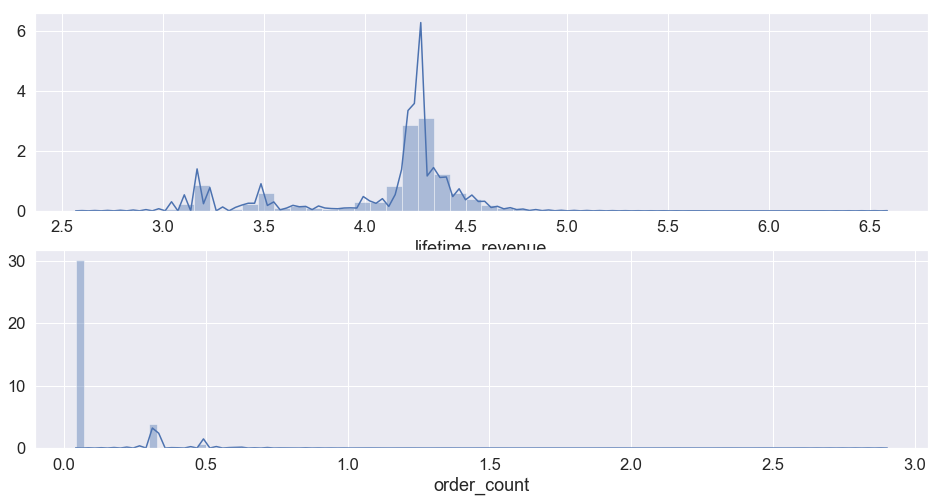

In [67]:
fig, ax = plt.subplots(2)
sns.distplot(np.log10(param_df['lifetime_revenue'].dropna() + 0.01), ax=ax[0])
sns.distplot(np.log10(param_df['order_count'].dropna() + 0.1), ax=ax[1], bins=100)

Outliers?

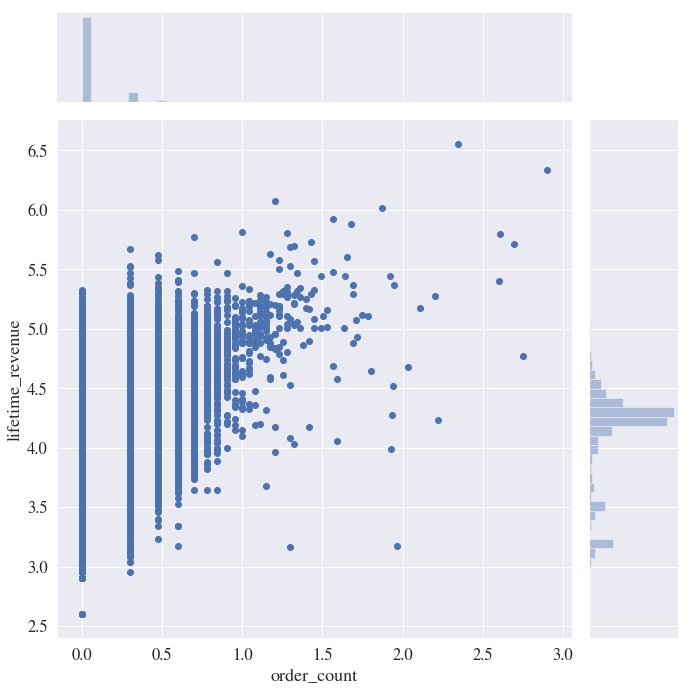

In [220]:
g = sns.JointGrid(x=np.log10(param_df.order_count), y=np.log10(param_df.lifetime_revenue), height=10)
g = g.plot_joint(plt.scatter, cmap='Blues_d')
g = g.plot_marginals(sns.distplot, kde=False)

#### Looking at order patterns of customers

In [40]:
param_df.groupby(['has_purchased_widget', 'has_purchased_trinket', 'has_purchased_gizmo'])['id'].count()

has_purchased_widget  has_purchased_trinket  has_purchased_gizmo
f                     f                      f                       18189
                                             t                        7275
                      t                      f                       75197
                                             t                        5929
t                     f                      f                      321486
                                             t                       12360
                      t                      f                       46816
                                             t                       24955
Name: id, dtype: int64

In [41]:
param_df.groupby(['has_purchased_widget', 'has_purchased_trinket', 'has_purchased_gizmo'])[['lifetime_revenue', 'order_count']].describe()

lifetime_revenue  \
                                                                          count   
has_purchased_widget has_purchased_trinket has_purchased_gizmo                    
f                    f                     f                            18098.0   
                                           t                             7275.0   
                     t                     f                            75197.0   
                                           t                             5929.0   
t                    f                     f                           321486.0   
                                           t                            12360.0   
                     t                     f                            46816.0   
                                           t                            24955.0   

                                                                              \
                                                                        mean   
has_purchased_widget has_purchased_trinket has_purchased_gizmo                 
f                    f                     f                     4046.479114   
                                           t                     4542.459519   
                     t                     f                     2283.537801   
                                           t                     8012.683420   
t                    f                     f                    19312.618525   
                                           t                    25548.836731   
                     t                     f                    23032.989961   
                                           t                    32830.577520   

                                                                              \
                                                                         std   
has_purchased_widget has_purchased_trinket has_purchased_gizmo                 
f                    f                     f                     2142.253295   
                                           t                     3036.114410   
                     t                     f                     1504.414615   
                                           t                     5245.600073   
t                    f                     f                     7329.542876   
                                           t                    10523.974669   
                     t                     f                    11053.936323   
                                           t                    34267.146452   

                                                                        \
                                                                   min   
has_purchased_widget has_purchased_trinket has_purchased_gizmo           
f                    f                     f                     400.0   
                                           t                     800.0   
                     t                     f                    1064.0   
                                           t                    1700.0   
t                    f                     f                    6241.0   
                                           t                    8110.0   
                     t                     f                    8286.0   
                                           t                    9792.0   

                                                                         \
                                                                    25%   
has_purchased_widget has_purchased_trinket has_purchased_gizmo            
f                    f                     f                     2589.0   
                                           t                     2800.0   
                     t                     f                     1500.0   
                                           t                     4900.0   
t                    f                     f   

#### Pearsons correlation between orders and lifetime revenue

In [42]:
param_df[['lifetime_revenue', 'order_count']].corr()

,lifetime_revenue,order_count
lifetime_revenue,1.000000,0.379579
order_count,0.379579,1.000000


In [43]:
param_df.groupby('id')[['lifetime_revenue', 'order_count']].sum().sort_values(by='lifetime_revenue', ascending=False)[:10]

,lifetime_revenue,order_count
id,,
9d8e721d-7643-4efb-a36c-5af338558dc0,3552371.0,222.0
13543c1a-f3ec-4aea-b349-22b4cd94006c,2183417.0,799.0
d64836ca-a6b2-49a0-9929-fab2bddf2af2,1181200.0,16.0
b3a1b375-75bb-437c-9f93-b08bca2765ab,1040300.0,74.0
094604c1-9b46-4f56-af07-809d5ec8edbe,837900.0,37.0
82d01a88-b3b9-477f-a828-6bce8871b091,760400.0,48.0
f43a6bc2-2008-4c76-a5ba-689cc89330ba,654500.0,10.0
3902e80a-1ad7-4587-96ef-f8dfbe7bbf07,640600.0,19.0
b3b3b8d9-86b1-4a94-a7a3-58b09049a095,621600.0,405.0


#### Checking unique values 

In [44]:
param_df.has_purchased_gizmo.unique(), param_df.has_purchased_trinket.unique(), param_df.has_purchased_widget.unique()

(array(['f', nan, 't'], dtype=object),
 array(['t', nan, 'f'], dtype=object),
 array(['f', nan, 't'], dtype=object))

#### average distance between first order and last order

In [45]:
(param_df['last_order_date'] - param_df['first_order_date']).dropna().apply(lambda x: x.days).describe()

count    512207.000000
mean         26.760421
std         105.798043
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1193.000000
dtype: float64

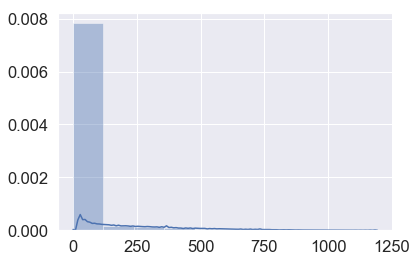

In [46]:
sns.distplot((param_df['last_order_date'] - param_df['first_order_date']).dropna().apply(lambda x: x.days), bins=10)

In [68]:
first_time_buyers = param_df[(param_df['last_order_date'] - param_df['first_order_date']).apply(lambda x: x.days) == 0]
first_time_buyers.head(5)

,id,has_purchased_widget,has_purchased_trinket,has_purchased_gizmo,order_count,first_order_date,last_order_date,lifetime_revenue
0,b559a1d3-5599-4223-92fb-f68d35f8bcb8,f,t,f,1.0,2017-01-23,2017-01-23,1700.0
10,39010c38-768c-4fef-8be8-7b9e55fff2bc,t,f,f,1.0,2016-09-09,2016-09-09,17000.0
12,a24adcaf-d6ea-47bc-8beb-343c2ab88b49,t,f,f,1.0,2016-09-15,2016-09-15,17000.0
13,44242033-3cd9-4bf6-a514-1a2730d66a71,t,f,f,1.0,2016-08-11,2016-08-11,17000.0
14,1e8162c3-4c94-4c4a-ad56-1531b1c2b4a1,t,f,f,1.0,2017-03-07,2017-03-07,29000.0


## Emails Dataset

In [7]:
email_df.head()

,id,event_time,event_type
0,0d170fdf-fc33-43be-9a62-c9b644525cf5,2017-04-25 19:00:51,email_send
1,1b44fece-d7dd-44f5-9ee9-a4ffe6999c70,2017-04-25 19:17:38,email_send
2,3f2e34a5-630c-4859-8677-39f5b07050f2,2017-04-25 19:17:38,email_send
3,125499e4-1986-4722-b9e5-e89e56443c41,2017-04-25 19:17:38,email_send
4,d7ee18ee-0155-463a-93c8-70eba7bcdf50,2017-04-25 19:17:38,email_send


In [8]:
email_df.describe(include='all')

,id,event_time,event_type
count,375626,375626,375626
unique,265736,48534,3
top,b4fe117c-c124-4445-a847-0fca26398002,2017-04-25 19:17:39,email_send
freq,921,12002,265737
first,NaN,2017-04-25 19:00:51,NaN
last,NaN,2017-05-21 23:56:04,NaN


In [9]:
email_df.isna().any()

id            False
event_time    False
event_type    False
dtype: bool

In [10]:
print(f'start of the campain: {email_df["event_time"].min()}, End of the campain: {email_df["event_time"].max()}')

start of the campain: 2017-04-25 19:00:51, End of the campain: 2017-05-21 23:56:04


In [11]:
email_df.sort_values(by='event_time', ascending=False).head()

,id,event_time,event_type
366916,56e5badd-83c9-45c3-af98-e42388ae0ee0,2017-05-21 23:56:04,email_open
366481,e65090e4-e66a-4e46-abe9-0ae7415b0337,2017-05-21 23:07:00,email_open
366480,e65090e4-e66a-4e46-abe9-0ae7415b0337,2017-05-21 23:04:36,email_open
366479,b1e4eeeb-7fb7-4a8f-8728-b067155a4c78,2017-05-21 22:28:59,email_open
367022,00a714d4-5de5-494c-8098-caa4fc9c9248,2017-05-21 21:37:39,email_open


#### When emails were sent

Text(0, 0.5, 'Email Sent')

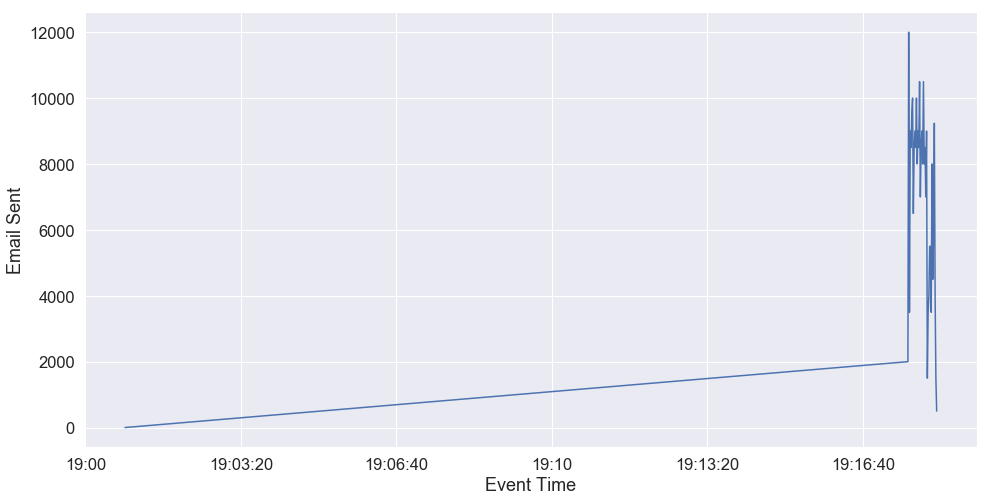

In [30]:
fig, ax = plt.subplots()
temp = email_df.set_index('event_time')
temp = temp[temp.event_type == 'email_send']
temp = temp.groupby(temp.index.time).count()['id']
temp.plot(ax=ax)
ax.set_xlabel('Event Time')
ax.set_ylabel('Email Sent')

In [34]:
temp = email_df.groupby(['event_time', 'event_type']).count().unstack()

#### wheren they where opened or clicked on

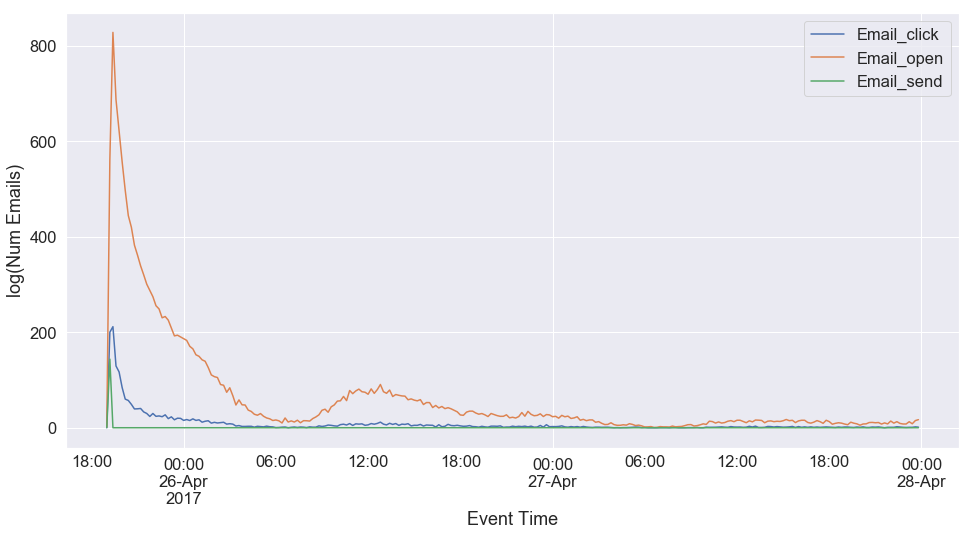

In [126]:
fig, ax = plt.subplots()
temp.applymap(lambda x: np.log10(x + 1))[:'2017-04-27'].resample('0.2H').sum().plot(ax=ax)
ax.set_xlabel('Event Time')
ax.set_ylabel("log(Num Emails)")
ax.legend(['Email_click', 'Email_open', 'Email_send'])
fig.savefig('image/figure2.png', bbox_inches='tight', dpi=300)

#### Looking at number of email sent to, opened or click by customer

In [190]:
email_df[email_df['event_type'] == 'email_send'].groupby(by=['id']).size().sort_values(ascending=False).head()

id
b56d6920-d07c-4579-ba36-533bcafad948    2
ffffb60e-bdc5-417a-971e-b14329e9e422    1
554ac225-1872-46ad-a2ed-e16f84faf6cd    1
5549b42d-de12-44dd-8089-5e5b2b9b7398    1
5549bdb9-d36c-43e2-8828-525e1d4d562a    1
dtype: int64

In [195]:
temp = email_df[email_df['event_type'] == 'email_open'].groupby(by=['id']).size().sort_values(ascending=False) 
outlier_ids = temp[temp > temp.mean() + temp.std() * 3]
outlier_ids.size

237

In [194]:
temp = email_df[email_df['event_type'] == 'email_click'].groupby(by=['id']).size().sort_values(ascending=False) 
outlier_ids = temp[temp > temp.mean() + temp.std() * 3]
outlier_ids.size

89

In [218]:
count = email_df.groupby('event_type')['id'].unique().apply(lambda x: x.size)
count = 100 * count / count.max()

In [219]:
count

event_type
email_click      2.703435
email_open      24.795286
email_send     100.000000
Name: id, dtype: float64

In [169]:
email_df.event_type.value_counts().divide(email_df.event_type.value_counts()['email_send']).multiply(100)

email_send     100.000000
email_open      38.115129
email_click      3.237411
Name: event_type, dtype: float64

#### ratio of email clicked or opened

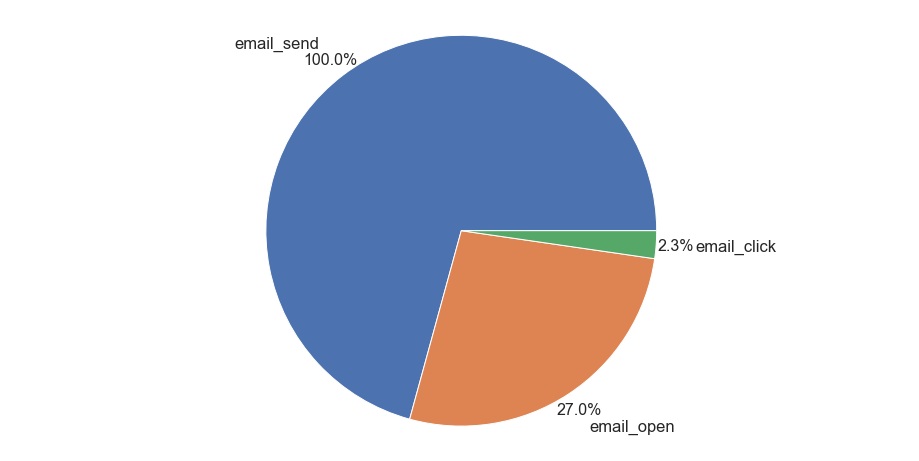

In [225]:
def func(pct, allvals):
    if pct == 70.74510455131531:
        pct = 100
    return "{:.1f}%".format(pct)

fig, ax = plt.subplots(1)
data.plot(kind='pie', ax=ax,
          autopct=lambda pct: func(pct, count),
           pctdistance=1.1,
           labeldistance=1.2)
ax.set_ylabel('')
ax.axis('equal')
fig.savefig('image/figure3.png', bbox_inches='tight', dpi=300)

#### this user opened recieved one email and opened it 920 time (incorrect measurement?)

In [64]:
email_df.groupby(by=['id', 'event_type']).count()['event_time'].max(), email_df.groupby(by=['id', 'event_type']).count()['event_time'].argmax()

(920.0, ('b4fe117c-c124-4445-a847-0fca26398002', 'email_open'))

In [65]:
email_df[email_df.id == 'b4fe117c-c124-4445-a847-0fca26398002']['event_type'].value_counts()

email_open     920
email_send       1
email_click      0
Name: event_type, dtype: int64

#### Calculating few metrics

In [226]:
# click through rate 

ctr = email_df[email_df.event_type == 'email_click']['id'].unique().size / (email_df[email_df.event_type == 'email_send']['id'].unique().size)

print(f'click through rate: {round(ctr * 100, 2)}%')

click through rate: 2.7%


In [227]:
# email open rate

eor = email_df[email_df.event_type == 'email_open']['id'].unique().size / (email_df[email_df.event_type == 'email_send']['id'].unique().size)

print(f'Email open rate: {round(eor * 100, 2)}%')

Email open rate: 24.8%


In [228]:
# click to open rate 

ctor = email_df[email_df.event_type == 'email_click']['id'].unique().size / (email_df[email_df.event_type == 'email_open']['id'].unique().size)

print(f'click to open rate: {round(ctor * 100, 2)}%')

click to open rate: 10.9%


In [69]:
# pd.merge(dummies, param_df, on='id', how='outer')

## Measuring campaign sucsess

In [4]:
print(f"number of unique customers in params dataset: {param_df['id'].unique().size}",
    f"number of unique customers in orders dataset: {orders_df['id'].unique().size}",
    f"number of unique customers emails in orders dataset: {email_df['id'].unique().size}", sep="\n")

number of unique customers in params dataset: 1307992
number of unique customers in orders dataset: 27149
number of unique customers emails in orders dataset: 265736


### finding the treatment and control group

In [5]:
all_id = param_df['id'].unique()
order_before =  param_df[(param_df.order_count > 1) & (param_df.last_order_date > '2016-04')]['id'].unique() #ordered before and in the past 12 months

treatment_id = email_df[(email_df.event_type == 'email_open') & (email_df.id.isin(order_before))]['id'].unique()
control_id = np.array(list(set(order_before) - set(treatment_id)))

#### difference betweeen orders in control and treatment group

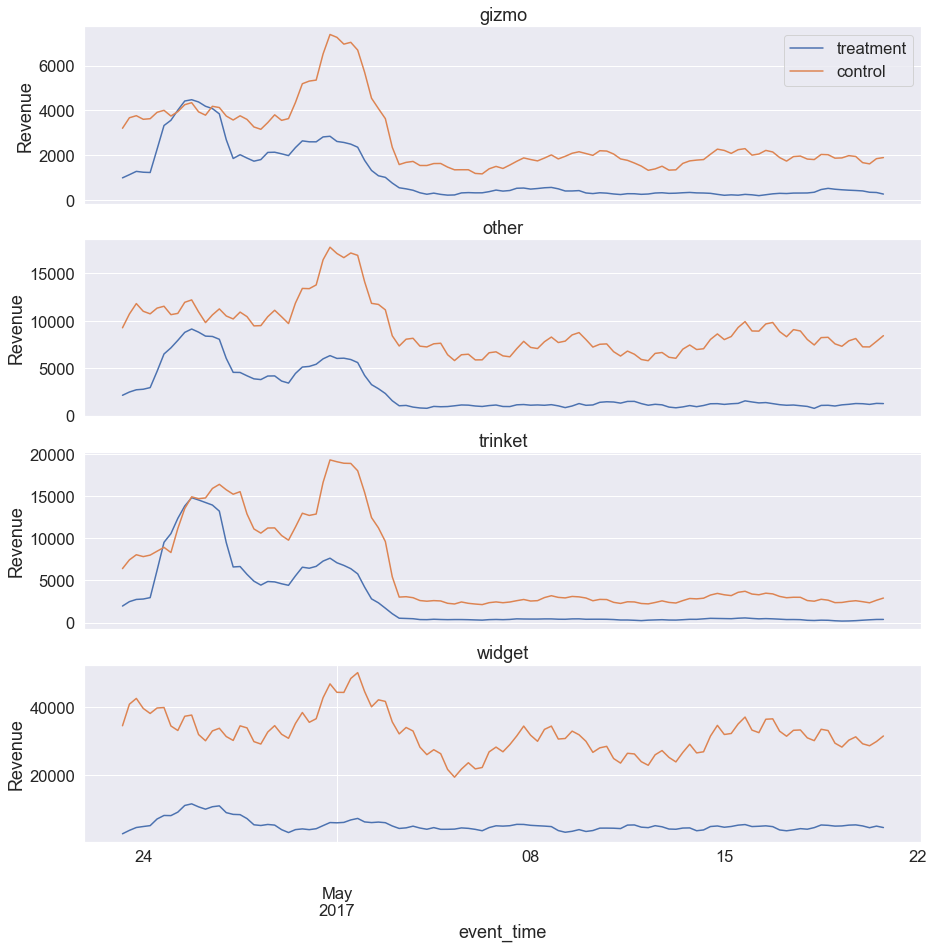

In [6]:
treat_temp = pd.pivot_table(orders_df[(orders_df.id.isin(treatment_id))], values='revenue', index='event_time', columns='product', aggfunc=np.sum)
control_temp = pd.pivot_table(orders_df[(orders_df.id.isin(control_id))], values='revenue', index='event_time', columns='product', aggfunc=np.sum)

fig, ax = plt.subplots(4, figsize=(15, 15))
for i, col in enumerate(['gizmo', 'other', 'trinket', 'widget']):
    treat_temp[col].resample('6H').sum().rolling(10, center=True, win_type='gaussian').sum(std=5).plot(ax=ax[i], label='treatment')
    control_temp[col].resample('6H').sum().rolling(10, center=True, win_type='gaussian').sum(std=5).plot(ax=ax[i], label='control')

    ax[i].set_title(col)
    ax[i].set_ylabel('Revenue')
    if i == 0:
        ax[i].legend()
    if i != 3:
        ax[i].axes.get_xaxis().set_visible(False)
        ax[i].set_xlabel('Event Time')



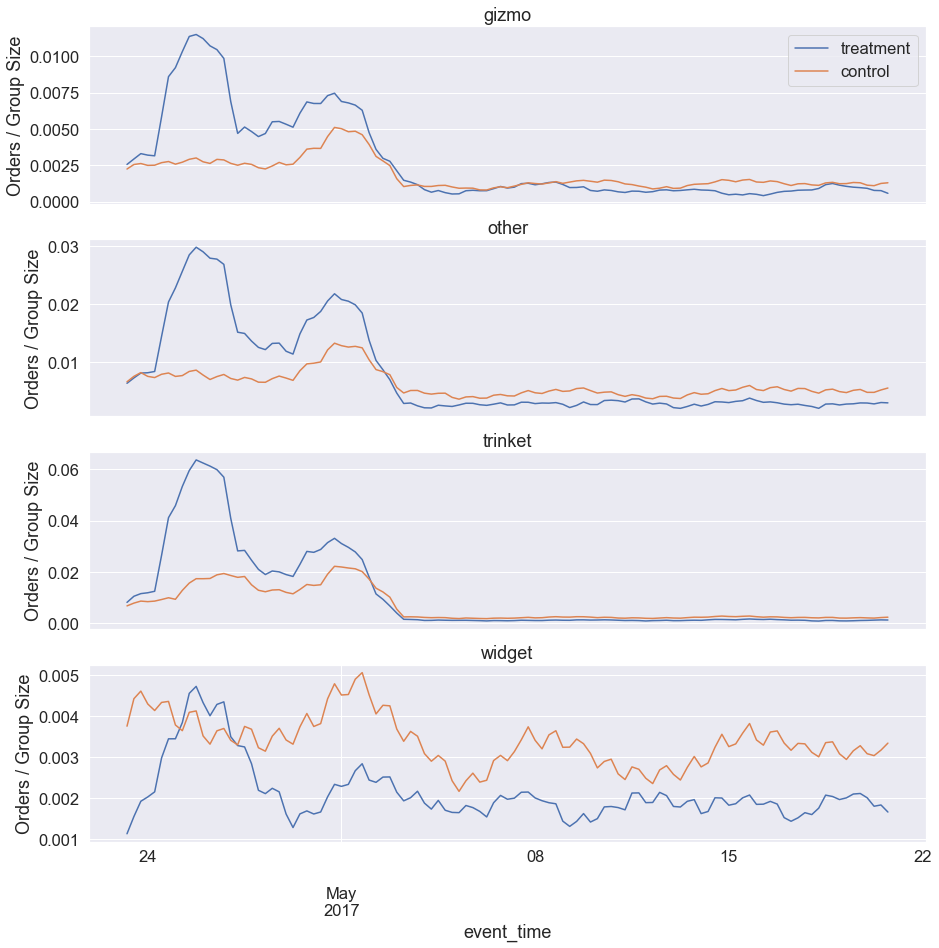

In [7]:
treat_temp = pd.pivot_table(orders_df[(orders_df.id.isin(treatment_id))], values='id', index='event_time', columns='product', aggfunc=np.size)
control_temp = pd.pivot_table(orders_df[(orders_df.id.isin(control_id))], values='id', index='event_time', columns='product', aggfunc=np.size)

fig, ax = plt.subplots(4, figsize=(15, 15))
for i, col in enumerate(['gizmo', 'other', 'trinket', 'widget']):
    treat_temp[col].resample('6H').sum().rolling(10, center=True, win_type='gaussian').sum(std=5).divide(treatment_id.size).plot(ax=ax[i], label='treatment')
    control_temp[col].resample('6H').sum().rolling(10, center=True, win_type='gaussian').sum(std=5).divide(control_id.size).plot(ax=ax[i], label='control')

    ax[i].set_title(col)
    ax[i].set_ylabel('Orders / Group Size')
    if i == 0:
        ax[i].legend()
    if i != 3:
        ax[i].axes.get_xaxis().set_visible(False)
        ax[i].set_xlabel('Event Time')

fig.savefig('image/figure4.png', bbox_inches='tight', dpi=300)    

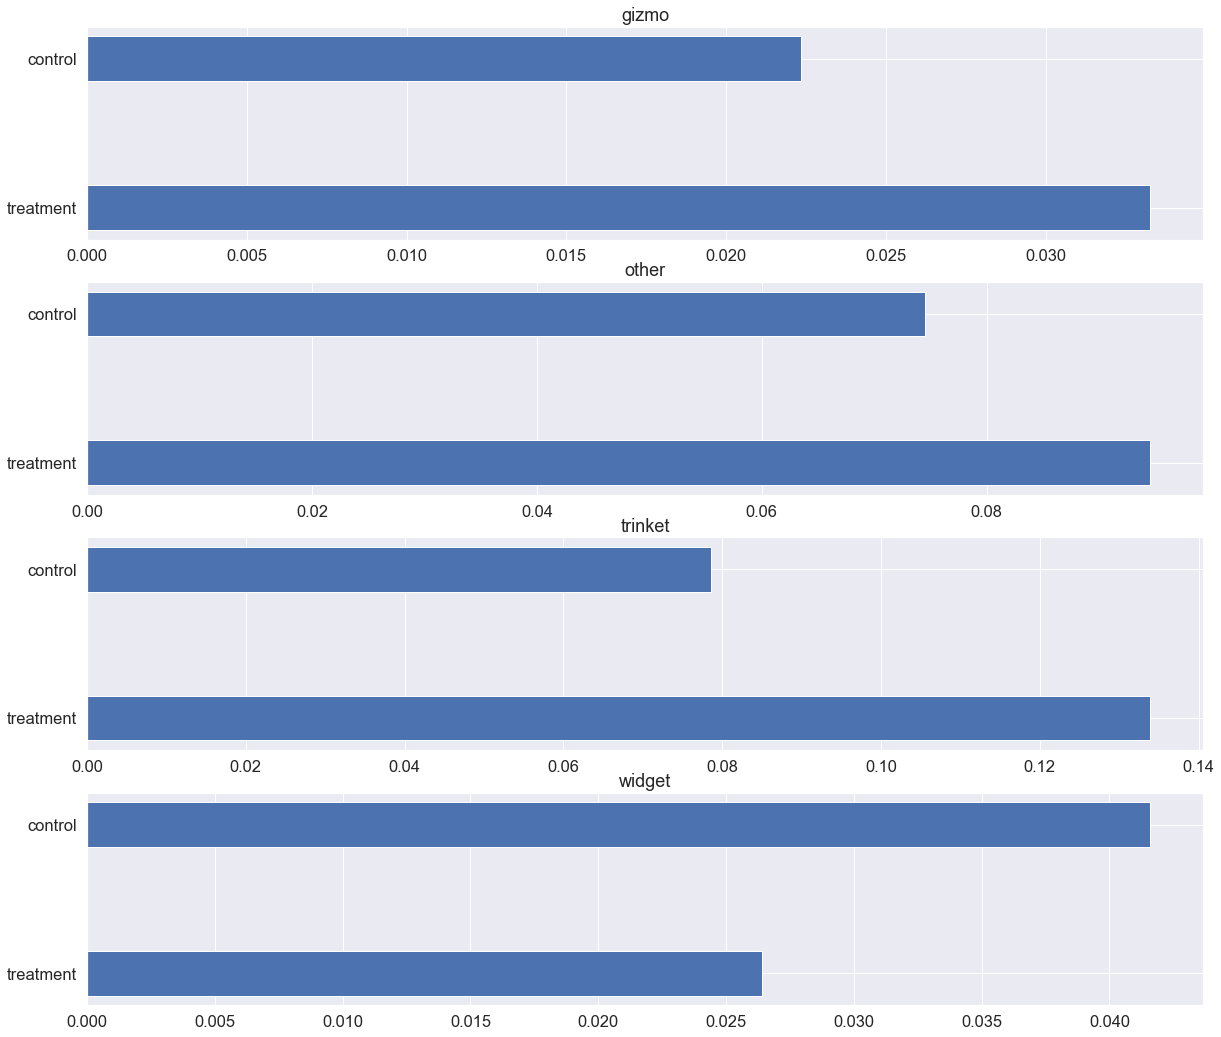

In [8]:
treat_temp = orders_df[(orders_df.id.isin(treatment_id)) & (orders_df.event_time > '2017-04-25')].groupby('product')['id'].count() / treatment_id.size
control_temp = orders_df[(orders_df.id.isin(control_id)) & (orders_df.event_time > '2017-04-25')].groupby('product')['id'].count() / control_id.size

fig, ax = plt.subplots(4, figsize=(20, 18))
for i, col in enumerate(['gizmo', 'other', 'trinket', 'widget']):
    ax[i].barh(y=[1, 2], width=[treat_temp[col], control_temp[col]], label=col, tick_label=['treatment', 'control'], height=0.3, )

    ax[i].set_title(col)

#### comparing distribution of order in control and treatment group


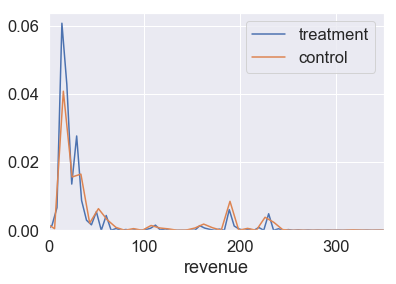

In [11]:

fig, ax = plt.subplots()
sns.distplot(orders_df[(orders_df.id.isin(treatment_id))  & (orders_df.event_time > '2017-04-25')]['revenue'], ax=ax, hist=False, kde=True, norm_hist=True, bins=100, label='treatment')
sns.distplot(orders_df[(orders_df.id.isin(control_id))  & (orders_df.event_time > '2017-04-25')]['revenue'], ax=ax, hist=False, kde=True, norm_hist=True, bins=100, label='control')
ax.set_xlim((0, 350))
ax.legend()

#### Convnersion rates

In [12]:
# Conversion rate treatment group
k = len(list(set(orders_df[orders_df.event_time > '2017-04-24']['id'].unique()) & set(treatment_id)))
n = treatment_id.size

R = round(100 * k / n, 2)
print(f"Treatment conversion rate: {R}")

Treatment conversion rate: 21.62


In [13]:
# conversion rate control group
k0 = len(list(set(orders_df[orders_df.event_time > '2017-04-24']['id'].unique()) & set(control_id)))
n0 = control_id.size

R0 = round(100 * k0 / n0, 2)


print(f"Control conversion rate: {R0}")

Control conversion rate: 12.0


In [14]:
print(f'Uplift: {R/R0 - 1}')

Uplift: 0.8016666666666667


In [44]:
# confindence interval for conversion rate
temp = []
for i in range(1000000):
    temp.append(np.random.beta(k+1, n-k+1))

In [45]:
# confindence interval for conversion rate (control)
temp0 = []
for i in range(1000000):
    temp0.append(np.random.beta(k0+1, n0-k0+1))

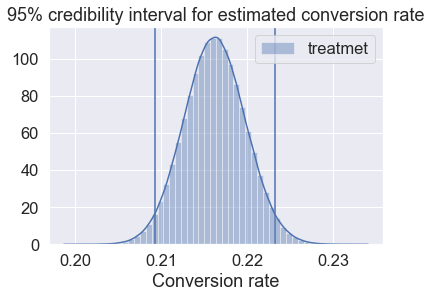

In [46]:
fig, ax = plt.subplots()
sns.distplot(temp, ax=ax, label='treatmet')
ax.axvline(np.quantile(temp, 0.025))
ax.axvline(np.quantile(temp, 0.975))
# sns.distplot(temp0, ax=ax, label='control')
# ax.axvline(np.quantile(temp0, 0.025))
# ax.axvline(np.quantile(temp0, 0.975))

ax.set_title('95% credibility interval for estimated conversion rate')
ax.set_xlabel('Conversion rate')
ax.legend()

fig.savefig('image/figure5.png', bbox_inches='tight', dpi=300)



#### credible interval

In [47]:
# Treatment
print(np.quantile(temp, 0.025))
print(np.quantile(temp, 0.975))

0.20925759804121613
0.2232503120492335


In [48]:
# Control 
print(np.quantile(temp0, 0.025))
print(np.quantile(temp0, 0.975))

0.11711927719642866
0.12289739869747093


#### uplift metric

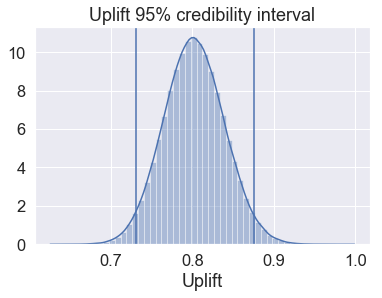

In [18]:
# calculalting lift

temp = []
for i in range(1000000):
    temp.append((np.random.beta(k+1, n-k+1) /np.random.beta(k0+1, n0-k0+1)) - 1)
    
fig, ax = plt.subplots()
sns.distplot(temp, ax=ax)
ax.axvline(np.quantile(temp, 0.025))
ax.axvline(np.quantile(temp, 0.975))

ax.set_title('Uplift 95% credibility interval')
ax.set_xlabel('Uplift')

fig.savefig('image/figure6.png', bbox_inches='tight', dpi=300)

In [19]:
for col in ['gizmo', 'other', 'trinket', 'widget']:
    print(col, ':', '%', round(100 * len(set(orders_df[orders_df.event_time > '2017-04-24'].groupby('product')['id'].unique()[col]) & set(treatment_id)) / treatment_id.size, 2)) 

gizmo : % 3.29
other : % 7.8
trinket : % 12.41
widget : % 2.6


In [20]:
for col in ['gizmo', 'other', 'trinket', 'widget']:
    print(col, ':', '%', round(100 * len(set(orders_df[orders_df.event_time > '2017-04-24'].groupby('product')['id'].unique()[col]) & set(control_id)) / control_id.size, 2)) 

gizmo : % 2.15
other : % 5.29
trinket : % 6.39
widget : % 3.97


#### comparing the reveneue in two groups (independent T-test)


In [21]:
# comparing the reveneue in two groups 
from statsmodels.stats.weightstats import ttest_ind

ttest_ind(orders_df[orders_df.id.isin(treatment_id)]['revenue'],orders_df[orders_df.id.isin(control_id)]['revenue'])

(-17.47866758901793, 8.597496797988542e-68, 16364.0)

In [22]:
param_df.head()

,id,has_purchased_widget,has_purchased_trinket,has_purchased_gizmo,order_count,first_order_date,last_order_date,lifetime_revenue
0,b559a1d3-5599-4223-92fb-f68d35f8bcb8,f,t,f,1.0,2017-01-23,2017-01-23,1700.0
1,fcd46843-a4a3-4c7b-bd89-14847303f566,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,05017c37-180b-4122-a528-0f5c78fc1010,NaN,NaN,NaN,NaN,NaT,NaT,NaN
3,5b41894b-52da-4269-9502-1b9eb0974193,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,2f74bc5c-c1c5-4a7a-a04d-e594d989a5ea,NaN,NaN,NaN,NaN,NaT,NaT,NaN


### uplift modeling

#### creating dataset and features

In [69]:
temp = param_df.dropna(how='all',
               subset=['has_purchased_widget', 'has_purchased_trinket',
               'has_purchased_gizmo', 'order_count', 'first_order_date',
               'last_order_date', 'lifetime_revenue'])
temp = temp[temp.id != '8be6334d-2c6a-4466-873b-fae44b7a4dc4']
temp = temp[(temp.id.isin(treatment_id)) | (temp.id.isin(control_id))]
temp = temp[(temp.last_order_date < '2017-05-22') & (temp.last_order_date > '2016-04')]

temp['treatment'] = 0
temp['treatment'][temp.id.isin(treatment_id)] = 1

temp[['has_purchased_widget', 'has_purchased_trinket','has_purchased_gizmo']] = temp[['has_purchased_widget', 'has_purchased_trinket','has_purchased_gizmo']].applymap(lambda x: 1 if x == 't' else 0) 
temp['days_since_last_order'] = (temp.last_order_date.max() - temp.last_order_date).apply(lambda x: x.days)
temp['days_since_first_order'] = (temp.last_order_date.max() - temp.first_order_date).apply(lambda x: x.days)
temp.drop(columns=['last_order_date', 'first_order_date'], inplace=True)
temp['response'] = 0
# temp['response'][(temp.id.isin(orders_df[(orders_df.event_time > '2016-04')]['id'].unique()))] = 1

temp['response'][(temp.id.isin(orders_df[(orders_df.event_time > '2016-04')]['id'].unique())) & temp['treatment']==1] = 1
temp['response'][(temp.response == 0) & (temp.treatment == 0)] = 1

In [70]:
temp.describe()

,has_purchased_widget,has_purchased_trinket,has_purchased_gizmo,order_count,lifetime_revenue,treatment,days_since_last_order,days_since_first_order,response
count,48339.000000,48339.000000,48339.000000,48339.000000,4.833900e+04,48339.000000,48339.000000,48339.000000,48339.000000
mean,0.800637,0.637911,0.283912,2.354455,2.502341e+04,0.236765,158.868326,353.498438,0.822007
std,0.399525,0.480609,0.450899,3.126919,2.471715e+04,0.425101,120.129801,242.264460,0.382511
min,0.000000,0.000000,0.000000,2.000000,9.000000e+02,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,2.000000,1.750000e+04,0.000000,46.000000,163.000000,1.000000
50%,1.000000,1.000000,0.000000,2.000000,2.240000e+04,0.000000,138.000000,302.000000,1.000000
75%,1.000000,1.000000,1.000000,2.000000,3.200000e+04,0.000000,248.000000,501.500000,1.000000
max,1.000000,1.000000,1.000000,560.000000,3.552371e+06,1.000000,414.000000,1125.000000,1.000000


#### Fitting logistic regression model with class over sampling (SMOTE)

In [74]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.combine import SMOTEENN


sm = SMOTEENN()
X = temp.drop(columns=['id', 'response', 'treatment'])
col_names = X.columns
Y = temp['response']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X, Y = sm.fit_sample(X, Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

X_train, y_train = sm.fit_sample(X_train, y_train)



clf = LogisticRegressionCV(cv=5, random_state=1234, Cs=10).fit(X_train, y_train)

#### Training metrics

In [75]:
print(classification_report(y_train, clf.predict(X_train))), print('accuracy:',accuracy_score(y_train, clf.predict(X_train)))

             precision    recall  f1-score   support

          0       0.59      0.69      0.64     16038
          1       0.60      0.49      0.54     15165

avg / total       0.60      0.59      0.59     31203

accuracy: 0.5946223119571836


(None, None)

#### Testing metrics

In [76]:
print(classification_report(y_test, clf.predict(X_test))), print('accuracy:',accuracy_score(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.61      0.69      0.65      7325
          1       0.57      0.48      0.52      6181

avg / total       0.59      0.59      0.59     13506

accuracy: 0.5938101584480971


(None, None)

#### Statsmodels logistic regression (better statistical metrics)

In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

print(res.summary2(xname=temp.drop(columns=['id', 'response', 'treatment']).columns))

Optimization terminated successfully.
         Current function value: 0.667822
         Iterations 6
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.030      
Dependent Variable:    y                  AIC:                41350.8196 
Date:                  2018-10-24 12:28   BIC:                41409.2003 
No. Observations:      30949              Log-Likelihood:     -20668.    
Df Model:              6                  LL-Null:            -21317.    
Df Residuals:          30942              LLR p-value:        6.4940e-277
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        6.0000                                            
-------------------------------------------------------------------------
                        Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
-------------------------------------------------------------------------
has_purchased_widget    -0.2656   0.0299

#### RandomForest alternative classifier for uplift model

In [37]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]
# # Number of features to consider at every split
# max_features = ['auto']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2]
# # Method of selecting samples for training each tree
# bootstrap = [True]
# # Create the random grida
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}


# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=0, random_state=1234, n_jobs = 4)
# rf_random.fit(X_train, y_train)

In [36]:
# print(classification_report(y_train, rf_random.predict(X_train))), print('accuracy:', accuracy_score(y_train, rf_random.predict(X_train)))

In [35]:
# print(classification_report(y_test, rf_random.predict(X_test))), print('accuracy:',accuracy_score(y_test, rf_random.predict(X_test)))

In [183]:
# from pylift import TransformedOutcome
# up = TransformedOutcome(temp.drop(columns='id'), col_treatment='treatment', col_outcome='response')
# _ = up.randomized_search(verbose=False, n_iter=10, n_jobs=6)
# up.fit(**up.rand_search_.best_params_)
# up.plot(plot_type='cgains', show_practical_max=True, show_no_dogs=True)

In [184]:
# from pylift.eval import UpliftEval
# upev = UpliftEval(temp.treatment, temp.response, clf.predict(X), n_bins=40)
# upev.plot()

#### Calculating Uplif value from uplift modeling

In [33]:
RT = pd.DataFrame(X, columns=col_names)
# RT['treatment'] = 1
RC = pd.DataFrame(X, columns=col_names)
# RC['treatment'] = 0


uplift = pd.DataFrame({'id': temp['id'], 'uplift': 2 * clf.predict_proba(RT)[:, 1] - 1})

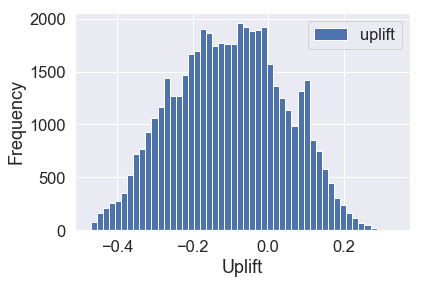

In [34]:
fig, ax = plt.subplots()
uplift.sort_values(by='uplift', ascending=False, inplace=True)
uplift.plot(kind='hist', bins=50, ax=ax)
ax.set_xlabel('Uplift')
fig.savefig('image/figure7.png', bbox_inches='tight', dpi=300)

In [42]:
uplift[uplift.uplift > 0].sort_values(by='uplift', ascending=False).head()

,id,uplift
144522,0d5be10d-f641-4d50-ae31-d50e787b0233,0.335421
481105,46d85024-0f54-46a4-8d24-2fb1ee3ca446,0.316277
215534,f3ca9a28-19b2-45bc-b81b-4b1a7eb75388,0.312626
369627,d693762a-892b-46f7-af04-574370184c1b,0.310896
1239477,7fae9dc6-528c-464e-9f4b-9ff40e375ac9,0.301481


In [50]:
uplift[uplift.uplift > 0].shape[0] /  uplift.shape[0]

0.25513560479116243